# Multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset has](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word blank (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

2. Modify the last layer of your model to Dense(4), as there are now four output classes.

3. When compiling the model, change the loss to tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True). This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, 1, 2, or 3). In addition, change the metrics to metrics=\['accuracy'], since this is a multi-class classification problem (tf.metrics.BinaryAccuracy is only used for binary classifiers).

4. When plotting accuracy over time, change binary_accuracy and val_binary_accuracy to accuracy and val_accuracy, respectively.

5. Once these changes are complete, you will be able to train a multi-class classifier.

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil # The shutil module offers a number of high-level operations on files and collections of files
import string # he built-in string class provides the ability to do complex variable substitutions and value formatting via the format() method described in PEP 3101.
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

2023-05-02 12:11:20.410759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 12:11:21.309028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download and explore the IMDB dataset

In [6]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow')

6053168/6053168 [==============================] - 2s 0us/step


In [8]:
dataset_dir, os.listdir(dataset_dir)

('./stack_overflow', ['test', 'train'])

In [9]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [27]:
sample_file = os.path.join(train_dir, 'python/2.txt')
with open(sample_file) as f:
    print(f.read())

"how to iterate through a blank defaultdict? i have a dictionary that looks like this...defaultdict(&lt;type 'list'&gt;,.{. 2012: [counter({1: 1, 2: 1, 4: 1}), 3],. 2013: [counter({4: 2, 12: 1, 5: 1, 6: 1}), 5],. 2014: [counter({4: 3, 1: 1, 2: 1, 3: 1}), 6]}.)...i am trying to iterate the through counter dict. like this...2012.1 1.2 1.1 4.3..2013.4 2.12 1.5 1.6 1.5...here is the code i tried...for key, value in d.iteritems():.    for k, v in value:.        print k, v...here is the error:..traceback (most recent call last):.  file ""c:/test.py"", line 42, in &lt;module&gt;.    for k, v in value:.valueerror: too many values to unpack...jinja2 solution:..{% extends ""base.html"" %}.{% block title %}archive{% endblock %}.{% block content %}..&lt;dl&gt;.{% for key, value in d.iteritems() %}.    &lt;dt&gt;&lt;a href=""/{{ key }}""&gt;{{ key }}&lt;/a&gt; ({{ value[1] }})&lt;/dt&gt;.    {% for m, c in value[0].items() %}.       &lt;dd&gt;&lt;a href=""/{{ key }}/{{ m }}""&gt;{{m|month_number}}&

## Load the dataset

In [15]:
# Dataset has already been divided into train and test, but it lacks a validation set.
# Get for validation 20% of the training data

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir+'/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2023-05-02 12:33:20.171285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 12:33:20.313867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 12:33:20.313964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 12:33:20.316230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 12:33:20.316281: I tensorflow/compile

In [22]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Label #:", label_batch.numpy()[i])
        print("Label:", raw_train_ds.class_names[i])
        print("Text part:", text_batch.numpy()[i][:100], '...')

2023-05-02 12:40:40.134725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-05-02 12:40:40.135012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]


Label #: 2
Label: csharp
Text part: b'"what is the difference between these two ways to create an element? var a = document.createelement(' ...
Label #: 0
Label: java
Text part: b'"is it possible to add a static object to a list in blank? i have a bunch of static classes i would ' ...
Label #: 1
Label: javascript
Text part: b'"discount sale gui i\'m encountering problems with my discount sale program. this program is supposed' ...


In [23]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [24]:
# Get for validation 20%

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir+'/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [25]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir+'/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


There are 8000 files, 6400 for traning and 1600 for validation.

## Prepare the dataset for training

Optional specification for [standardization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to apply to the input text. Values can be:
None: No standardization.
"lower_and_strip_punctuation": Text will be lowercased and all punctuation removed.
"lower": Text will be lowercased.
"strip_punctuation": All punctuation will be removed.
Callable: Inputs will passed to the callable function, which should standardized and returned.

In [38]:
max_features = 100000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [39]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2023-05-02 12:54:52.785724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2023-05-02 12:54:52.786036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]


In [40]:
# Let’s create a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the defau

In [41]:
print("2722 ---> ",vectorize_layer.get_vocabulary()[1886])
print("3111 ---> ",vectorize_layer.get_vocabulary()[4])
print("   8 ---> ",vectorize_layer.get_vocabulary()[216])
print(" 394 ---> ",vectorize_layer.get_vocabulary()[6])
print("   4 ---> ",vectorize_layer.get_vocabulary()[71])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2722 --->  "trying
3111 --->  to
   8 --->  convert
 394 --->  a
   4 --->  list
Vocabulary size: 100000


In [42]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create and compile the model

In [81]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    # layers.Dense(128, activation='relu'),
    # layers.Flatten(),
    # layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4)])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 16)          1600016   
                                                                 
 dropout_15 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 1,600,084
Trainable params: 1,600,084
Non-trainable params: 0
___________________________________________

In [82]:
# When compiling the model, change the loss to tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True). This is the correct
# loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can
# be 0, 1, 2, or 3). In addition, change the metrics to metrics=['accuracy'], since this is a multi-class classification problem
# (tf.metrics.BinaryAccuracy is only used for binary classifiers).

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [83]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 20s 100ms/step - loss: 1.3774 - accuracy: 0.3536 - val_loss: 1.3649 - val_accuracy: 0.4737
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 1.3461 - accuracy: 0.4906 - val_loss: 1.3250 - val_accuracy: 0.5281
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2900 - accuracy: 0.5661 - val_loss: 1.2638 - val_accuracy: 0.5663
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 1.2109 - accuracy: 0.6278 - val_loss: 1.1933 - val_accuracy: 0.6044
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1187 - accuracy: 0.6881 - val_loss: 1.1253 - val_accuracy: 0.6212
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 1.0302 - accuracy: 0.7311 - val_loss: 1.0635 - val_accuracy: 0.6525
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.9443 - accuracy: 0.7714 - val_loss: 1.0066 - val_accuracy: 0.6719
Epo

## Evaluate the model and create a plot

In [84]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 3ms/step - loss: 0.8888 - accuracy: 0.7057
Loss:  0.8888326287269592
Accuracy:  0.7057499885559082


In [85]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

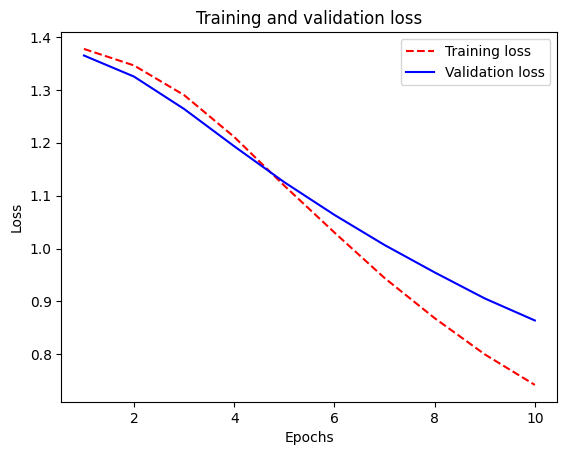

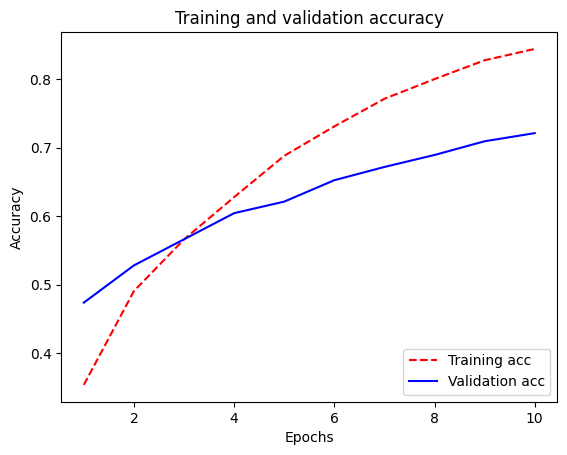

In [86]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In [87]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 8s 29ms/step - loss: 0.8888 - accuracy: 0.7057
0.7057499885559082


## Inference on new data

In [88]:
examples = [
    "How can I get keys from the dataframe",
    "During defining a class I got an error",
    "in chrome I can get access to the variable",
    "print('hello world')",
    "using Oracle",
    "microsoft windows",
    'ubuntu',
    'server',
    'data',
    'pandas',
    'python',
    'javascript',
    'C#'
]

print(raw_train_ds.class_names)
export_model.predict(examples)

['csharp', 'java', 'javascript', 'python']
1/1 [==============================] - 0s 81ms/step


array([[0.49966377, 0.45333838, 0.54903746, 0.48337188],
       [0.5201182 , 0.49127275, 0.5171596 , 0.44792902],
       [0.49847212, 0.44519553, 0.56987315, 0.4708217 ],
       [0.50336355, 0.47094923, 0.55004674, 0.45331997],
       [0.51156497, 0.47295606, 0.54158986, 0.4503061 ],
       [0.5301451 , 0.4834898 , 0.52390355, 0.43428728],
       [0.5064612 , 0.48138592, 0.53824407, 0.45039788],
       [0.5172998 , 0.4858914 , 0.5322869 , 0.43742254],
       [0.5138473 , 0.4765437 , 0.53652495, 0.44886452],
       [0.5041683 , 0.4735905 , 0.540268  , 0.4616965 ],
       [0.51071334, 0.4830744 , 0.5392512 , 0.441256  ],
       [0.51402223, 0.4805074 , 0.5358988 , 0.44410208],
       [0.5048659 , 0.4729626 , 0.5464193 , 0.45295975]], dtype=float32)